#### Similar to the `compare lig_res_interactions_by_type`, the goal here is compare interactions between simulations, only here is about specific residues, not specific interactions

This used to be a same part of that script when it was a sandbox script, but I figured it would be best that this is alone now


This is going to be used to measure how interactions are between conditions (eg showing that crystal sims don't have very different fingerprints, whereas EM does)

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import prolif as plf
import MDAnalysis as mda
import pandas as pd
import seaborn as sns

sys.path.append('../')
import src.analysis_functions as analysis_functions
import src.simulation_metadata as sims

In [53]:
sim_list = [sims.PfHT_MMV_crystal, 
            sims.PfHT_MMV8_crystal, 
            sims.W412A_MMV_crystal,
            #sims.GLUT3_MMV_crystal
            ]

sim_list = [sims.PfHT_MMV12, 
            sims.PfHT_MMV8, 
            sims.W412A_MMV12,
#            #sims.GLUT3_MMV_crystal
            ]

color_l = [sim.color for sim in sim_list]

all_unis, all_lens = analysis_functions.load_unis(
    sim_list= sim_list
)


In [54]:
all_fp_dfs = {}
skip = 1

for sim in sim_list:
    temp_fp_dfs = []
    for n, rep_fp in enumerate(all_unis[sim.name]):
        df = analysis_functions.get_fp_dataframe(
            u=rep_fp,
            skip=skip,
            run_calc=False,
            filename=f"{sim.name}.replica_{n+1}.skip{skip}",
        )
        temp_fp_dfs.append(df)
    all_fp_dfs[sim.name] = temp_fp_dfs


# Calculate percentage of whatever interaction you want
Just find where t.ex TRP412 (or equivalent) is in the dataframe, then take mean

#### Pt 1 - First function `mean_intxns_per_res_wide` will output a df for one residue. You can plot this directly comparing interaction types

##### `res_map` will help with residue numbering and labeling, since it's different between PfHT and GLUTs osv

In [55]:
res_map = {"W412":{'PfHT1':'TRP391', 'GLUT1':'TRP381'},
           "Q169":{'PfHT1':'GLN148', 'GLUT1':'GLN154'},
           "Q305":{'PfHT1':"GLN284"},
           "Q306":{'PfHT1':"GLN285"},
           "N341":{'PfHT1':'ASN320'}
           
           }


In [56]:
341-21

320

#### then, use this function to get the mean interactions per residue. Will return a wide dataframe with the top level being protein condition, the lower level being the replica, and index being interaction type

In [57]:
def mean_intxns_per_res_wide(
        resname: str,
        all_fp_dfs: dict=all_fp_dfs,
        res_map: dict=res_map,
        sim_list: list=sim_list,
        mean_cutoff: int=0.1,
) -> pd.DataFrame:
    '''
    Will loop through the sim_list
    For each element in list, loop through all reps of this element, finding the 
    fingerprint for the given residue. This is dictated by res_map, seen in the cell above
    
    Find all intxns for this res, then combine all replicas (mean_intxn_all_reps), 
    then combine all conditions, left with a wide dataframe called mean_intxn_all_conds
    '''
    
    mean_intxn_all_conds = {}
    for sim in sim_list:
        replica_names = [f"replica {i}" for i in range(1, sim.n_replicas + 1)]

        ### group replicas as cols into a wide dataframe
        mean_intxn_all_reps = []
        for rep in all_fp_dfs[sim.name]:

            #res_map[resname][PfHT1] will return TRP391 for W412, t.ex
            # need a special case for w412
            if "W412" in sim.name and resname == 'W412':
                try:
                    mean_intxn = rep["ALA391"].mean()
                except KeyError:
                    pass ## passing is fine because will become nan later
            else:
                try:
                    mean_intxn = rep[res_map[resname][sim.protein]].mean()
                except KeyError:
                    pass
            mean_intxn = mean_intxn.loc[mean_intxn > mean_cutoff]
            mean_intxn_all_reps.append(mean_intxn)
        mean_intxn_all_reps = pd.concat(mean_intxn_all_reps, axis=1, keys=replica_names)
        
        ### then group conditions as cols into wide(r) dataframe
        mean_intxn_all_conds[sim.name] = mean_intxn_all_reps
    mean_intxn_all_conds = pd.concat(mean_intxn_all_conds, axis=1)

    return mean_intxn_all_conds

In [58]:
mean_intxn_all_conds = mean_intxns_per_res_wide(
                                                resname='Q169',
                                                sim_list=sim_list,
                                                all_fp_dfs=all_fp_dfs
                                            )

mean_intxn_all_conds = mean_intxn_all_conds.fillna(0)
#mean_intxn_all_conds = mean_intxn_all_conds.drop('Hydrophobic') #I don't find this so useful, remove

#### use `analysis_functions.process_df_wide` to make this into a long form dataframe

In [40]:
mean_intxn_all_conds = analysis_functions.process_wide_df(
    df=mean_intxn_all_conds,
    index_col_name='interaction',
    index_name='interaction',
    top_level_melt_name='protein',
    lower_level_melt_name='replica'
)

#### plot in seaborn

(0.0, 1.0)

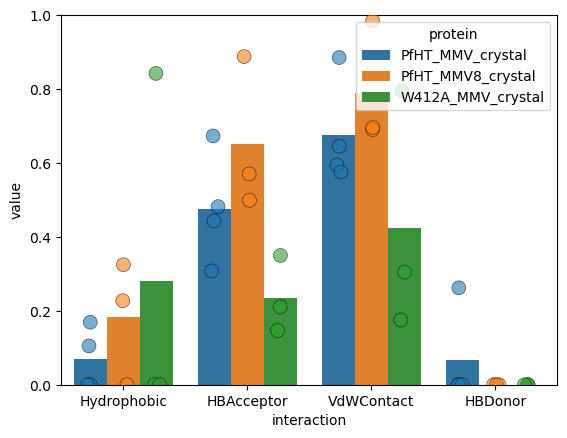

In [42]:
f,ax=plt.subplots(1,1)
sns.barplot(data=mean_intxn_all_conds,
            y='value', 
            x='interaction', 
            hue='protein',
            ax=ax,
            errorbar=None)


sns.stripplot(
    data=mean_intxn_all_conds,
    y='value',
    x='interaction',
    hue='protein',
    ax=ax,
    dodge=True,
    alpha=0.6,
    edgecolor="black",
    linewidth=0.5,
    legend=False,
    size=10,
)

ax.set_ylim(0,1)

<Axes: >

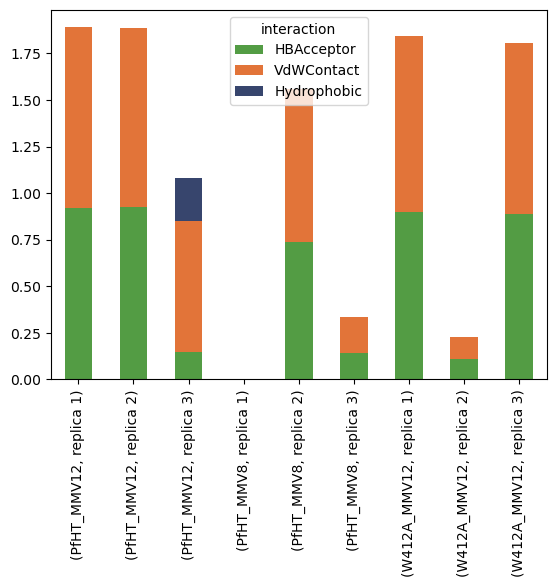

In [59]:
mean_intxn_all_conds.T.plot.bar(stacked=True, color=color_l)  #this is before making longform

In [60]:
mean_intxn_all_conds

PfHT_MMV12                     PfHT_MMV8                      \
             replica 1 replica 2 replica 3 replica 1 replica 2 replica 3   
interaction                                                                
HBAcceptor    0.918082  0.925075  0.147852       0.0  0.738889  0.142695   
VdWContact    0.972028  0.963037  0.702298       0.0  0.822222  0.191393   
Hydrophobic   0.000000  0.000000  0.230769       0.0  0.000000  0.000000   

            W412A_MMV12                      
              replica 1 replica 2 replica 3  
interaction                                  
HBAcceptor     0.900407  0.110889  0.888143  
VdWContact     0.943089  0.115884  0.917226  
Hydrophobic    0.000000  0.000000  0.000000